In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import bluepysnap as bp

# Extracts spike times for each simulation

In [4]:
path_to_simulation = '../hippocampusSim/'
s = bp.Simulation(path_to_simulation+'simulation_config_small.json') # Loads simulation object
population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

In [5]:
types = np.sort(list(s.circuit.nodes.property_values('mtype'))) # Cell types

In [6]:
index = 0

path_to_spikes = '../hippocampusSim/pkls/'

# Iterates through all regions and cell types and concatenates spike reports loaded from pickle files (produced by getSpikes.py)
for t in types[:-1]:
    
    report = pd.read_pickle(path_to_spikes+'/spikes_'+t+'.pkl')
    
    if index == 0:
        spikeReports = report
    else:
        spikeReports = pd.concat((spikeReports,report))

    index += 1

In [7]:
index = 0

path_to_spikes = '../hippocampusSim/pkls_big/'

# Iterates through all regions and cell types and concatenates spike reports loaded from pickle files (produced by getSpikes.py)
for t in types[:-1]:
    
    report = pd.read_pickle(path_to_spikes+'/spikes_'+t+'.pkl')
    
    if index == 0:
        spikeReports_big = report
    else:
        spikeReports_big = pd.concat((spikeReports_big,report))

    index += 1

# Loads LFP

In [8]:
s = bp.Simulation(path_to_simulation+'simulation_config_big.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    for iteration in range(numIter):
        p = pd.read_pickle('../hippocampusSim/pkls_big/eeg_'+t+'_'+str(iteration)+'.pkl')
        if iteration == 0:
            s = p
        else:
            s += p
        
    signals.append(s)

totalSignal = 0
for s in signals:
    totalSignal += s

s = bp.Simulation(path_to_simulation+'simulation_config_small.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals_small = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    p = pd.read_pickle('../hippocampusSim/pkls/eeg_'+t+'.pkl')
        
    signals_small.append(p)

totalSignal_small = 0
for s in signals_small:
    totalSignal_small += s

totalSignal -= np.mean(totalSignal.loc[1000:10000],axis=0)
totalSignal_small -= np.mean(totalSignal_small.loc[1000:10000],axis=0)

# Plots panels c and d in Figure 7

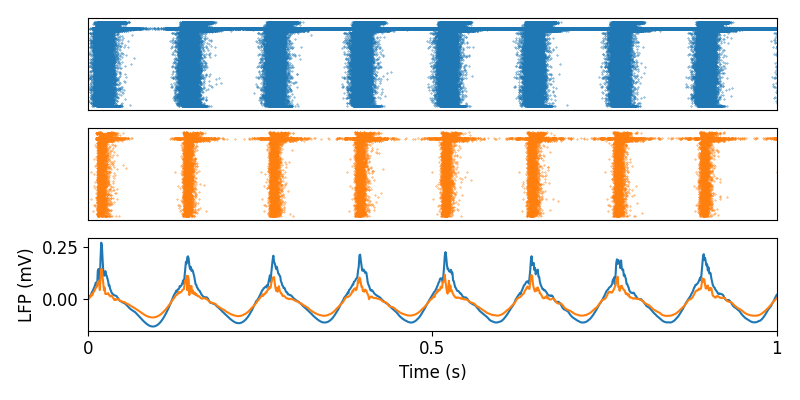

In [9]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot(3,1,1)
plt.scatter(spikeReports_big.index,spikeReports_big.values,s=.1)
ax1.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
plt.xlim([10000,11000])

ax2 = plt.subplot(3,1,2)
plt.scatter(spikeReports.index*1e-3,spikeReports.values,s=.1,c='C1')
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
plt.xlim([10.000,11.000])


ax3 = plt.subplot(3,1,3)
ax3.plot(totalSignal[6]*1e3)
ax3.plot(totalSignal_small[6]*1e3)
ax3.set_xlim([10000,11000])
ax3.set_xticks([10000,10500,11000],labels=['0','0.5','1'])
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('LFP (mV)')
ax3.set_xlabel('Time (s)')

plt.tight_layout()

plt.savefig('figures/spikes.png')